In [1]:
import os
import glob
import time
from tqdm import tqdm
import ast

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

In [39]:
cm = sns.light_palette("green", as_cmap=True)

In [40]:
def resultExtractor(val,feature):
    try:
        return ast.literal_eval(val)[feature]
    except:
        return np.nan

In [41]:
# CF_1 = pd.read_csv("../results/Collaborative filtering/CF gridsearch results.csv")
# CF_2 = pd.read_csv("../results/Collaborative filtering/CF baseline gridsearch results.csv")

# CF_3 = pd.read_csv("../results/Collaborative filtering/CF baseline als gridsearch results.csv")

In [42]:
# Results version
run = 2
path = f"../results/Collaborative filtering/run {run}/"

In [43]:
csv_files = glob.glob(os.path.join(path, "*.csv"))


In [44]:
df = pd.DataFrame()
for i in csv_files:
    df = pd.concat([pd.read_csv(i),df],axis=0).reset_index(drop=True)

In [45]:
# df = pd.concat([CF_1,CF_2,CF_3],axis=0)

#df = pd.read_csv(f"../results/Collaborative filtering/run {2}/Wide CF gridsearch results.csv")

In [46]:
#df.sort_values(by=["mean_test_fcp",'mean_test_mae','mean_test_mae'],ascending=True)

In [47]:
df["user_based"] = df.param_sim_options.apply(lambda x: resultExtractor(x,"user_based"))

df["similarity"] = df.param_sim_options.apply(lambda x: resultExtractor(x,'name'))

df["min_support"] = df.param_sim_options.apply(lambda x: resultExtractor(x,'min_support'))
df["shrinkage"] = df.param_sim_options.apply(lambda x: resultExtractor(x,'shrinkage'))
df["biased"] = df.param_sim_options.apply(lambda x: resultExtractor(x,'biased'))




In [49]:
df["side_info"] = np.nan
try: 
    assert df.model.str.contains("cmf_").sum() >0
    for index, row in df.iterrows():
        if "cmf_" in row.model:
            #df.loc[index,["model","param_biased","side_info"]] = row.model.split("_",maxsplit=2)
            #print(df.loc[index,"model"])
            values = row.model.split("_",maxsplit=2)
            df.loc[index,"model"] = values[0]
            df.loc[index,"param_biased"] = values[1]
            df.loc[index,"side_info"] = values[2]
            
except:
    print("side info separated")


In [51]:
df.sort_values(by=["mean_test_fcp",'mean_test_rmse','mean_test_mae'],ascending=True)


df_rmse = df.sort_values(by=['mean_test_rmse'],ascending=True)
df_mae = df.sort_values(by=['mean_test_mae'],ascending=True)
df_fcp =df.sort_values(by=["mean_test_fcp"],ascending=True)

In [52]:
for i in df.columns:
    if "iter" in i:
        print(i)

param_niter
param_maxiter


In [53]:
df[["model","mean_test_mae","similarity","user_based","min_support","shrinkage"]]

,model,mean_test_mae,similarity,user_based,min_support,shrinkage
0,KNNBasic,1.302915,pearson,False,2.0,0.0
1,KNNBasic,1.302915,pearson,False,2.0,5.0
2,KNNBasic,1.302915,pearson,False,2.0,10.0
3,KNNBasic,1.302915,pearson,False,2.0,20.0
4,KNNBasic,1.302915,pearson,False,2.0,100.0
...,...,...,...,...,...,...
6217,cmf,1.296578,NaN,NaN,NaN,NaN
6218,cmf,3.659348,NaN,NaN,NaN,NaN
6219,cmf,3.659348,NaN,NaN,NaN,NaN
6220,cmf,3.659348,NaN,NaN,NaN,NaN


In [54]:
# The best overall model
display(df_rmse.sort_values(by=['mean_test_rmse','rank_test_rmse'],ascending=True).loc[0,"model"])
display(df_mae.sort_values(by=['mean_test_mae','rank_test_mae'],ascending=True).loc[0,"model"])
display(df_fcp.sort_values(by=['mean_test_fcp','rank_test_fcp'],ascending=True).loc[0,"model"])

# At this moment baseline adjusted Matrix factorization is performs the best out of the models

'KNNBasic'

'KNNBasic'

'KNNBasic'

In [56]:
def best_model_plot(data,ranking,performance):
    # Best feature space for each model
    idx = pd.IndexSlice
    df_by_model = data.groupby("model").apply(lambda x: x.sort_values(by=ranking,ascending=True))#[["mean_test_mae","similarity","user_based","min_support","shrinkage"]]#.iloc[idx[:,1]]
    best_by_model = pd.DataFrame()
    for i in df_by_model.index.levels[0]:
        best_by_model = pd.concat([best_by_model,df_by_model.loc[idx[i,:],:].iloc[[0],:]], axis=0)
    display(best_by_model[[ranking,"similarity","user_based","min_support","shrinkage","param_biased","param_k", "param_n_factors","side_info","param_niter"]].sort_values(by=ranking).style.background_gradient(cmap=cm))
    linechart = best_by_model[[i for i in best_by_model.columns if (("split" in i)&((performance in i)))]].reset_index().drop(columns="level_1").set_index("model").transpose()#.sort_index(axis=1)
    fig, ax = plt.subplots(figsize=(8, 6))
    BROWN = "#AD8C97"
    BROWN_DARKER = "#7d3a46"
    GREEN = "#2FC1D3"
    BLUE = "#076FA1"
    GREY = "#C7C9CB"
    GREY_DARKER = "#5C5B5D"
    RED = "#E3120B"
    model_names = {"KNNBaseline":"Baseline centered","KNNBasic":"Raw prediction",
                   "KNNWithMeans":"Mean centered","KNNWithZScore":"Z-score standardization",
                   "SVD":"Matrix Factorization","cmf":"Collective Matrix Factorization"}
    # Add lines with dots
    # Note the zorder to have dots be on top of the lines
    for percentage, color in zip(linechart.columns, [BLUE, GREEN, BROWN,GREY,RED, BROWN_DARKER]):
        ax.plot([1,2,3], linechart[percentage].values, color=color, lw=5, label=percentage)
        ax.scatter([1,2,3], linechart[percentage].values, fc=color, s=100, lw=1.5, ec="white", zorder=12)
        ax.xaxis.set_ticks([1,2,3])
        ax.text(x=3.02,y=linechart[percentage].values[-1],s=model_names[percentage],color=color)
    ax.set_xlabel("cross validation split")
    ax.set_ylabel(performance)

,,mean_test_rmse,similarity,user_based,min_support,shrinkage,param_biased,param_k,param_n_factors,side_info,param_niter
model,,,,,,,,,,,
SVD,1167,1.484499,nan,nan,nan,nan,True,nan,10.000000,nan,nan
KNNBaseline,3411,1.492879,cosine,True,18.000000,0.000000,nan,101.000000,nan,nan,nan
KNNWithZScore,539,1.668928,cosine,True,18.000000,100.000000,nan,101.000000,nan,nan,nan
KNNWithMeans,899,1.668937,cosine,True,18.000000,100.000000,nan,101.000000,nan,nan,nan
cmf,5289,1.693556,nan,nan,nan,nan,bias,50.000000,nan,themes,30.000000
KNNBasic,339,1.693586,pearson_baseline,True,14.000000,100.000000,nan,101.000000,nan,nan,nan


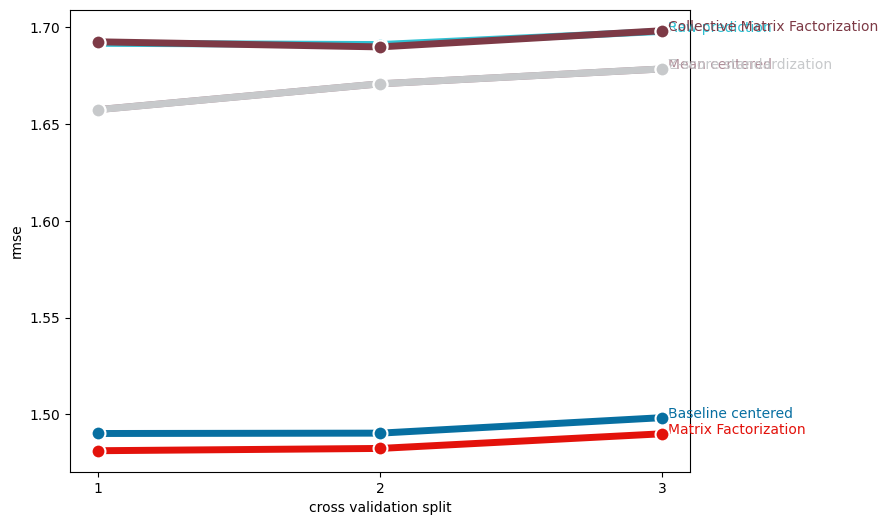

In [57]:
best_model_plot(df,"mean_test_rmse","rmse")

,,mean_test_mae,similarity,user_based,min_support,shrinkage,param_biased,param_k,param_n_factors,side_info,param_niter
model,,,,,,,,,,,
SVD,1169,1.106731,nan,nan,nan,nan,True,nan,10.000000,nan,nan
KNNBaseline,4230,1.114091,MSD,True,18.000000,5.000000,nan,101.000000,nan,nan,nan
KNNWithZScore,539,1.245249,cosine,True,18.000000,100.000000,nan,101.000000,nan,nan,nan
KNNWithMeans,899,1.245255,cosine,True,18.000000,100.000000,nan,101.000000,nan,nan,nan
cmf,6056,1.296330,nan,nan,nan,nan,bias,50.000000,nan,rank,30.000000
KNNBasic,339,1.296528,pearson_baseline,True,14.000000,100.000000,nan,101.000000,nan,nan,nan


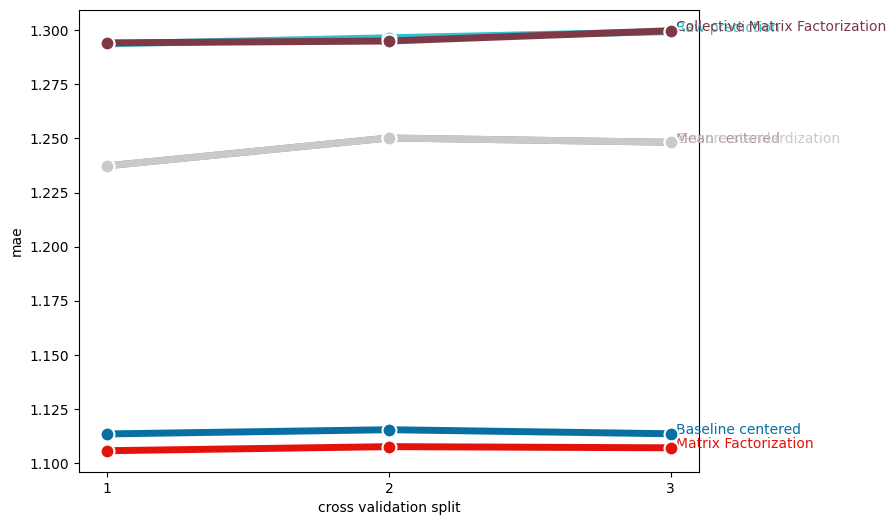

In [58]:
best_model_plot(df,"mean_test_mae","mae")

In [21]:
# best_model_plot(df,"mean_test_fcp","fcp")

In [ ]:
# We can see that pearson baseline similarity models the user-specific rating behaviour more accurately
# User-based model performs better than item-based models for this dataset

In [136]:
# def add_label(x, y, fontsize, ax):
#     PAD = 0.4
#     ax.annotate(
#         f"#{int(y)} in\n{str(int(x))[2:]}s", 
#         xy=(x, y - PAD), 
#         ha="center", 
#         va="bottom",
#         fontsize=fontsize,
#         fontname="Lato",
#         zorder=12
#     )

# def plot_country(country, data, annotate, ax):
    
#     for country_inner in data["model"].unique():
#         d = data[data["model"] == country_inner] 
#         x = [1,2,3]
#         y = d.iloc[:,2:].values[0]

#         if country_inner == country:
#             print(y)
#             ax.plot(x, y, color="#0b53c1", lw=2.4, zorder=10)
#             ax.scatter(x, y, fc="w", ec="#0b53c1", s=60, lw=2.4, zorder=12)
#             if annotate:
#                 add_label(x[0], y[0], 10, ax)
#                 add_label(x[-1], y[-1], 10, ax)
#         else:
#             ax.plot(x, y, color="#BFBFBF", lw=1.5)

#     ax.set_yticks([])
#     ax.set_xticks([1, 2, 3])
#     ax.set_xticklabels(
#         ["split 1", "split 2", "split 3"], 
#         fontsize=10,

#     )
#     ax.tick_params(bottom=False)
#     ax.set_frame_on(False)

#     ax.set_title(country, fontsize=14, fontweight=500)
    
#     return ax

# fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(14, 7.5))
# for idx, (ax, country) in enumerate(zip(axes.ravel(), df_by_model.index.levels[0])):
#     # Only annotate the first panel
#     annotate = idx == 0
#     plot_country(country, best_by_model[[i for i in best_by_model.columns if (("split" in i)&(("rmse" in i)))]].reset_index(), annotate, ax)

# # Since sharey=True, all vertical axis are inverted when we invert it in one subplot.
# ax.invert_yaxis()

In [59]:
# For CMF how do the different side informations fair
df[df.model =="cmf"].groupby("side_info").mean()[["mean_test_rmse","mean_test_mae"]].style.background_gradient(cmap=cm)


/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_19229/3096317901.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[df.model =="cmf"].groupby("side_info").mean()[["mean_test_rmse","mean_test_mae"]].style.background_gradient(cmap=cm)


,mean_test_rmse,mean_test_mae
side_info,,
cat,3.105113,2.721015
game_info,3.178972,2.738599
mechanics,3.105097,2.721059
rank,3.133168,2.724989
subcat,3.105101,2.721022
themes,3.105097,2.721059


In [61]:
# For CMF how do the different hyperparameters (K and Lambda) fair
df[df.model =="cmf"].groupby(["param_lambda_","param_k"]).mean()[["mean_test_rmse","mean_test_mae"]].style.background_gradient(cmap=cm)


/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_19229/4179606340.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[df.model =="cmf"].groupby(["param_lambda_","param_k"]).mean()[["mean_test_rmse","mean_test_mae"]].style.background_gradient(cmap=cm)


In [ ]:
# 

In [64]:
# Comparison of KNN models for user-based/item-based
df.groupby(["model","user_based"]).mean()[['mean_test_rmse',"mean_test_mae"]].style.background_gradient(cmap=cm)


/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_19229/3031137088.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(["model","user_based"]).mean()[['mean_test_rmse',"mean_test_mae"]].style.background_gradient(cmap=cm)


In [65]:
# Comparion of KNN models for similarity measures
df.groupby(["model","similarity"]).mean()[['mean_test_rmse',"mean_test_mae"]].style.background_gradient(cmap=cm)

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_19229/3193300215.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(["model","similarity"]).mean()[['mean_test_rmse',"mean_test_mae"]].style.background_gradient(cmap=cm)


In [66]:
# Comparion of KNN models for minimum support measures
df.groupby(["model","min_support"]).mean()[['mean_test_rmse',"mean_test_mae"]].style.background_gradient(cmap=cm)

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_19229/3343484583.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(["model","min_support"]).mean()[['mean_test_rmse',"mean_test_mae"]].style.background_gradient(cmap=cm)


In [68]:
# Comparion of KNN models for shrinkage measures
df[df.similarity=="pearson_baseline"].groupby(["model","shrinkage"]).mean()[['mean_test_rmse',"mean_test_mae"]].style.background_gradient(cmap=cm)

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_19229/3584394030.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[df.similarity=="pearson_baseline"].groupby(["model","shrinkage"]).mean()[['mean_test_rmse',"mean_test_mae"]].style.background_gradient(cmap=cm)


In [69]:
# SVD for bias
df.groupby(["model","param_biased"]).mean()[['mean_test_rmse',"mean_test_mae"]].style.background_gradient(cmap=cm)

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_19229/2263661122.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(["model","param_biased"]).mean()[['mean_test_rmse',"mean_test_mae"]].style.background_gradient(cmap=cm)


A natural question that arises is why this formulation should perform better than un- constrained matrix factorization. The addition of constraints on the last two columns of the factor matrices should only reduce the global solution quality, because one is now optimizing over a smaller space of solutions. However, in many cases, adding such constraints biases the solution while reducing overfitting. In other words, the addition of such intuitive con- straints can often improve the generalizability of the learning algorithm to unseen entries, even though the error over the specified entries may be higher. This is particularly helpful when the number of observed ratings for a user or for an item is small [473]. Bias variables add a component to the ratings that are global to either the users or the items. Such global properties are useful when limited data is available. As a specific example, consider the case in which a user has provided ratings for only a small number (1 or 2) items. In such cases, many recommendation algorithms, such as neighborhood-based methods, will not give reli- able predictions for the user. On the other hand, the (non-personalized) predictions of the item bias variables will be able to give reasonable predictions. After all, if a particular movie is a box-office hit on a global basis, then the relevant user is also more likely to appreciate it. The bias variables will also reflect this fact and incorporate it into the learning algorithm.
In fact, it has been shown [73, 310, 312] that using only the bias variables (i.e., k = 0) can often provide reasonably good rating predictions.

In [70]:
# Patterns of the best model
df[df.model == "KNNBaseline"].groupby(["similarity","min_support"]).mean()[['mean_test_rmse',"mean_test_mae"]].style.background_gradient(cmap=cm)

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_19229/1400695619.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[df.model == "KNNBaseline"].groupby(["similarity","min_support"]).mean()[['mean_test_rmse',"mean_test_mae"]].style.background_gradient(cmap=cm)


In [ ]:
plt.figure()
plt.plot(theta_values, Squared_error)
plt.xlabel('Theta Values')
plt.ylabel('Squared Error')
plt.show()